In [1]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/j7zymbjelxlf4v5meujq32s27bbirf')
labels=['Positive', 'Neutral', 'Negative', 'Highly positive', 'Highly negative']
percent=0.2
sentiment_counts=df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].value_counts()
for i in range(len(labels)):
  df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==labels[i]]=df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==labels[i]].nlargest(int(percent*sentiment_counts[i]),'which_of_these_sentiment_scores_does_the_above_image_fit_into_best:confidence')
labels=['Highly positive', 'Positive', 'Neutral', 'Negative', 'Highly negative'][::-1]
df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best'].value_counts()


Positive           1710
Neutral             845
Negative            423
Highly positive      86
Highly negative      56
Name: which_of_these_sentiment_scores_does_the_above_image_fit_into_best, dtype: int64

In [2]:
import os
os.mkdir('/content/images')
directories=['train','valid','test']
for directory in directories:
  os.mkdir('/content/images/'+directory)
  for j, label in enumerate(labels):
    os.mkdir('/content/images/'+directory+'/'+str(j))

In [3]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=c62763ecacb89f0db10575d843641bf135a9bf028a8ed058ae5e0b2180e3c1d5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [4]:
import threading
import wget

def download_img(url,directory,label,i):
  try:
    wget.download(url, '/content/images/'+directory+'/'+label+'/img'+i+'.jpg', )
  except:
    pass
for i, label in enumerate(labels):
  urls = df[df['which_of_these_sentiment_scores_does_the_above_image_fit_into_best']==label]['imageurl']
  n1_split=int(len(urls)*0.8)
  n2_split=int(len(urls)*0.95)
  n=0
  for j, url in enumerate(urls):
    if n<n1_split:
      directory=directories[0]
    elif n<n2_split:
      directory=directories[1]
    else:
      directory=directories[2]
    threading.Thread(target=download_img, args= (url,directory,str(i),str(j),)).start()
    n+=1

In [5]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch

TRAIN_DATA_PATH = "/content/images/train/"
VALID_DATA_PATH = "/content/images/valid/"
TEST_DATA_PATH = "/content/images/test/"

DATA_TRANSFORM = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])
BATCH_SIZE = 32
train_data=datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=DATA_TRANSFORM)
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data=datasets.ImageFolder(root=VALID_DATA_PATH, transform=DATA_TRANSFORM)
valid_dl = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_data=datasets.ImageFolder(root=TEST_DATA_PATH, transform=DATA_TRANSFORM)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

images-size: torch.Size([32, 3, 224, 224])
out-size: torch.Size([3, 228, 1132])


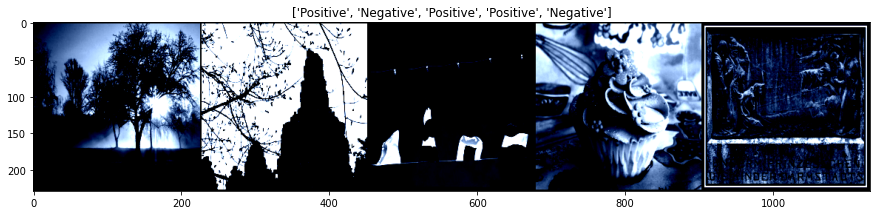

In [6]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt


def imshow(inp, title=None):
    figure = plt.figure(figsize=(15, 15))
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, classes = next(iter(test_dl))
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images[:5])
print("out-size:", out.shape)

imshow(out, title=[labels[x] for x in classes[:5]])

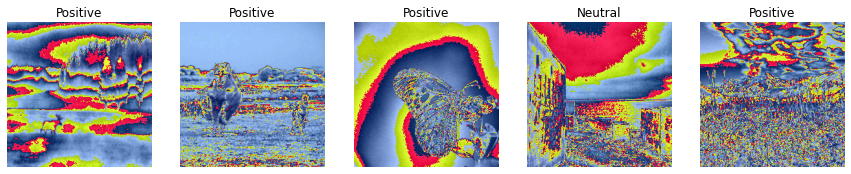

In [7]:
to_pil = transforms.ToPILImage()
images, classes = next(iter(test_dl))
images, classes = images[:5], classes[:5]
fig=plt.figure(figsize=(15,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    sub.set_title(labels[classes[ii].item()] )
    plt.axis('off')
    plt.imshow(image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


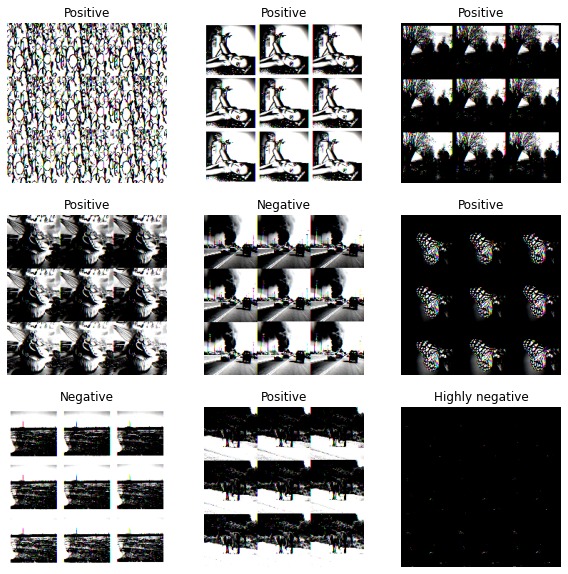

In [8]:
import matplotlib.pyplot as plt
X_test, Y_test = iter(test_dl).next()
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.title(labels[Y_test[i]])
    plt.axis("off")
    plt.imshow(X_test[i].reshape(224,224,3))
plt.show()

In [9]:
import torchvision

model = torchvision.models.resnet152(pretrained=True)
for p in model.parameters():
    p.requires_grad = False

out_dim = 5
model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, out_dim))
model.load_state_dict(model.state_dict())
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [10]:
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
def train_model(EPOCHS = 10, LEARNING_RATE = 0.05, WEIGHT_DECAY = 0.001):
  pbar = tqdm(total=EPOCHS*len(train_dl))
  optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

  model.train()#
  #best_f1=0
  iter=0
  for epoch in range(EPOCHS):
    for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
      #model.train()
      X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

      Xtr = X_train_batch
      Y_pred = model(Xtr)

      loss = criterion(Y_pred,Y_train_batch)
      
      Y_pred = torch.argmax(Y_pred, 1)

      f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')
      
      acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      pbar.update()
      #X_valid, Y_valid = iter(valid_dl).next()
      #model.eval()
      #X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
      #Xvl = X_valid
      #Y_pred = model(Xvl)  
      #valid_loss = criterion(Y_pred,Y_valid)

      #Y_pred = torch.argmax(Y_pred, 1)
      #valid_f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

      #valid_acc = sum(Y_valid == Y_pred)/len(Y_pred)
      #if (valid_f1>best_f1):
       # best_f1=valid_f1
        #torch.save(model.state_dict(), '/content/best_weights.pkl')
      if iter%100:
        loss_list.append(loss)
        f1_list.append(f1)
        acc_list.append(acc)
      iter+=1
    #valid_loss_list.append(valid_loss)
    #valid_f1_list.append(valid_f1)
    #valid_acc_list.append(valid_acc)
  pbar.close()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def eval_model(classes=5):
  X_true, Y_true = iter(test_dl).next()
  model.eval()
  X_true, Y_true = X_true.to(device), Y_true.to(device)
  Xvl = X_true
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_true)

  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_true.cpu(), Y_pred.cpu(), average='macro')

  acc = sum(Y_true == Y_pred)/len(Y_pred)

  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true.cpu(), Y_pred.cpu())
  lclasses = labels
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()
  print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

In [ ]:
loss_list = []
f1_list = []
acc_list = []
valid_loss_list = []
valid_f1_list = []
valid_acc_list = []

  0%|          | 0/314 [00:00<?, ?it/s]

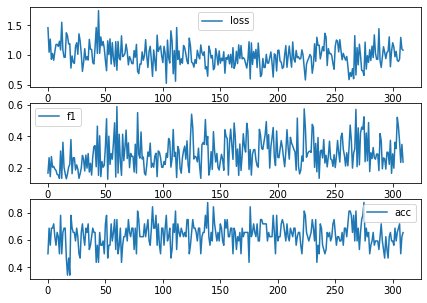

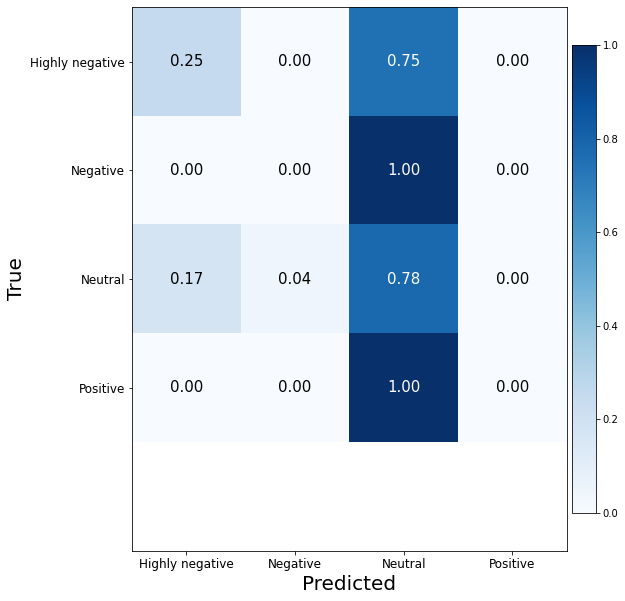

Loss:0.95, F1:0.24, Acc:0.59


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.1, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

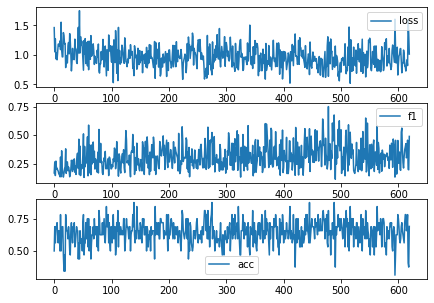

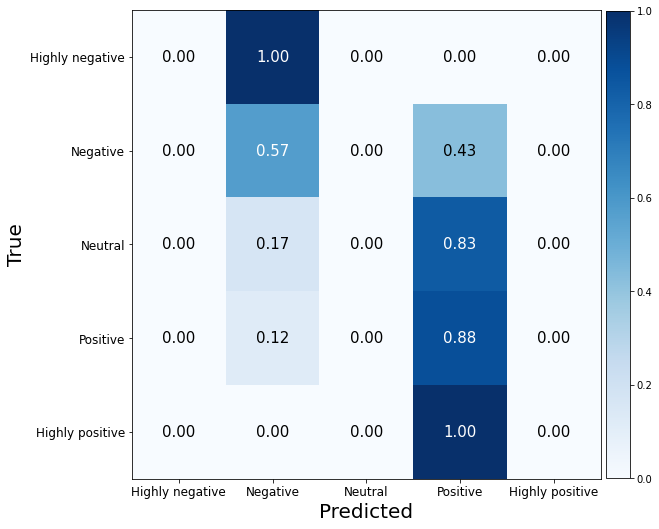

Loss:1.18, F1:0.25, Acc:0.59


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.1, WEIGHT_DECAY=0.05)

  0%|          | 0/314 [00:00<?, ?it/s]

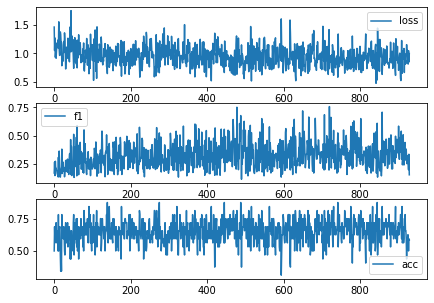

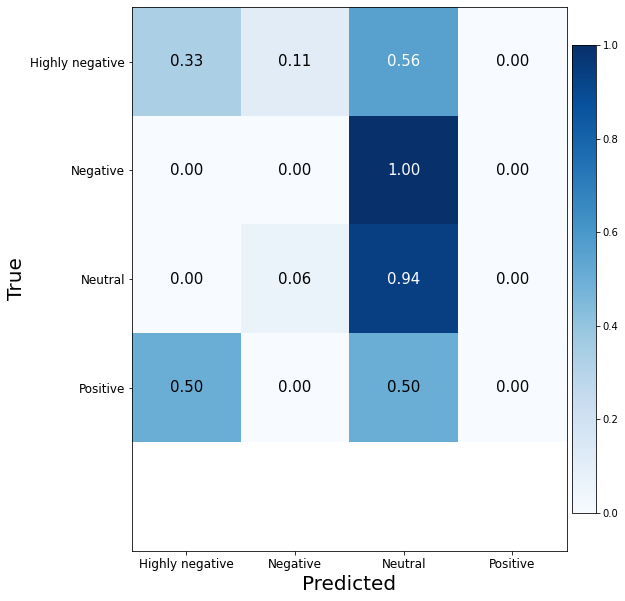

Loss:1.00, F1:0.29, Acc:0.56


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.1, WEIGHT_DECAY=0.5)

  0%|          | 0/314 [00:00<?, ?it/s]

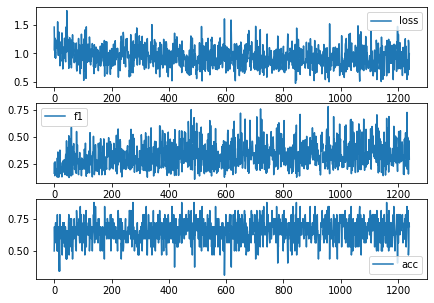

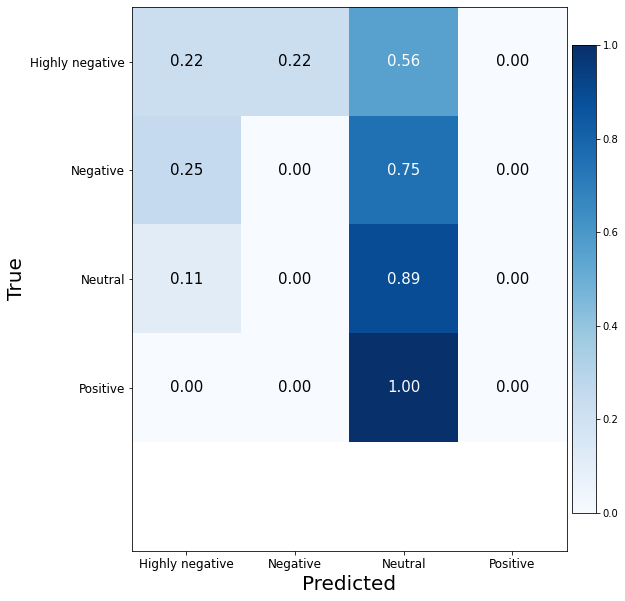

Loss:0.94, F1:0.26, Acc:0.56


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.1, WEIGHT_DECAY=1)

  0%|          | 0/314 [00:00<?, ?it/s]

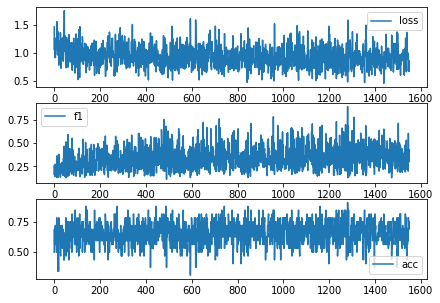

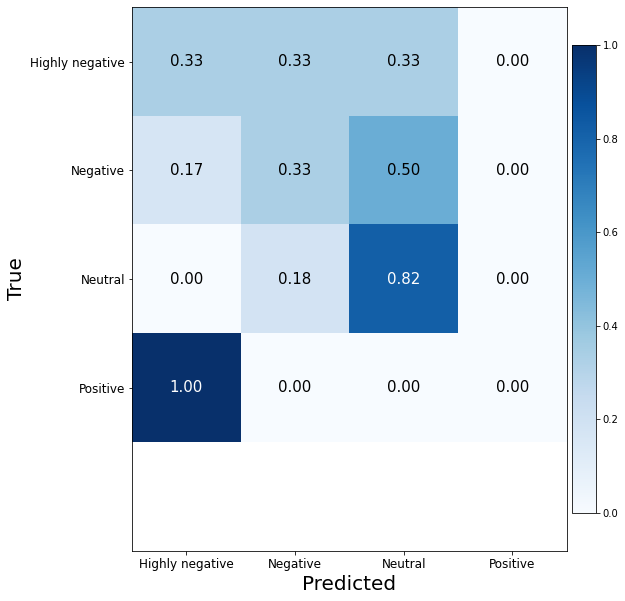

Loss:0.84, F1:0.36, Acc:0.66


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.05, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

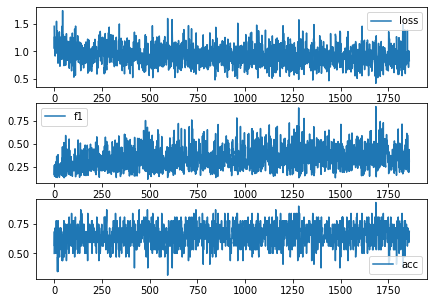

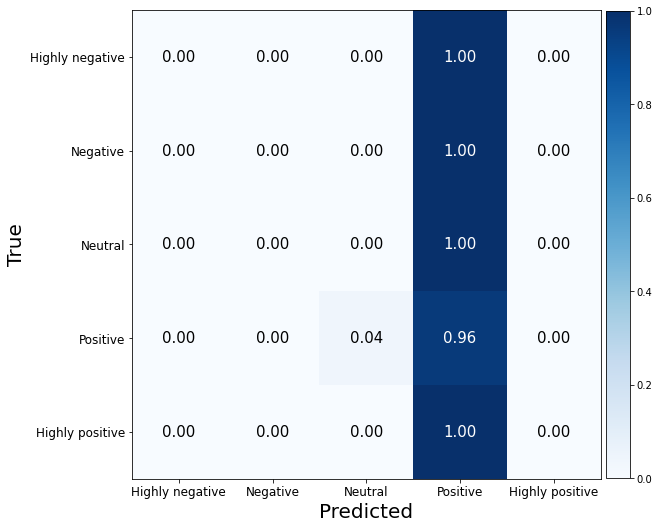

Loss:0.80, F1:0.17, Acc:0.72


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.01, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

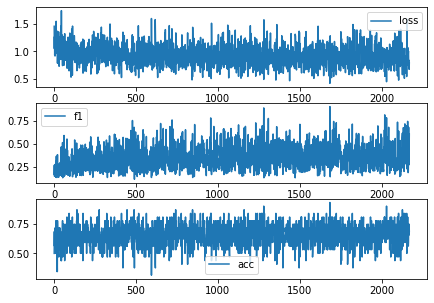

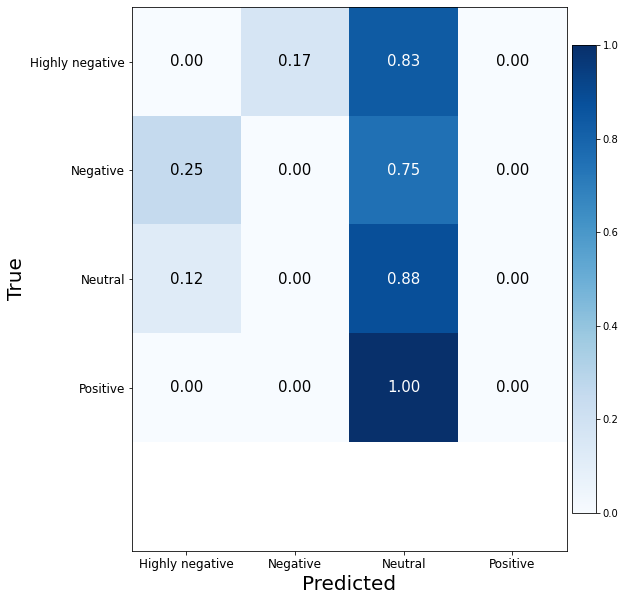

Loss:1.32, F1:0.17, Acc:0.47


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.005, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

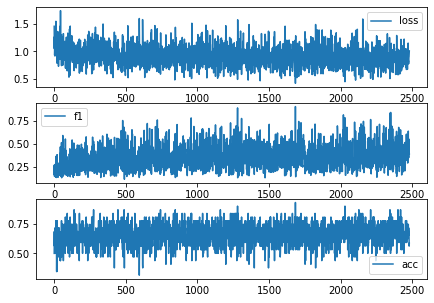

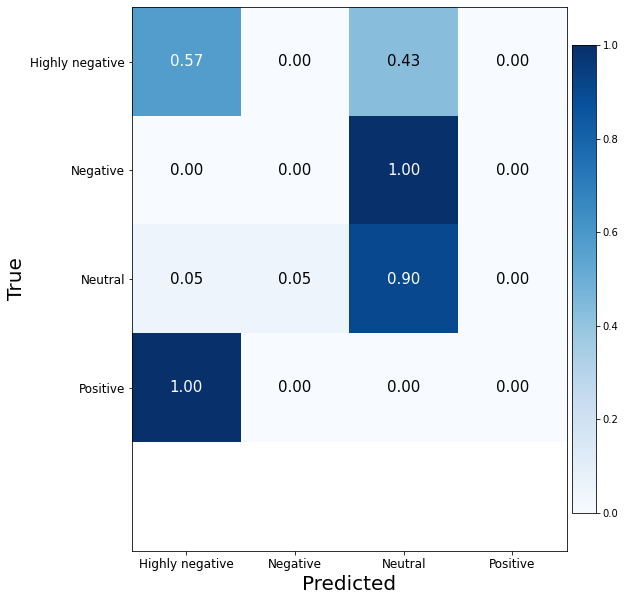

Loss:0.92, F1:0.36, Acc:0.72


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.001, WEIGHT_DECAY=0.005)

  0%|          | 0/314 [00:00<?, ?it/s]

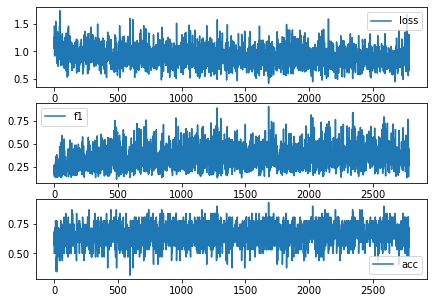

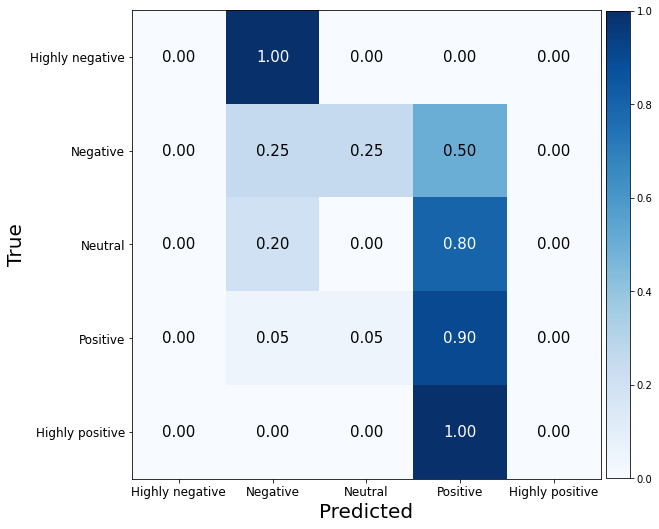

Loss:0.98, F1:0.21, Acc:0.59


In [ ]:
exp(EPOCHS=1,LEARNING_RATE=0.0001, WEIGHT_DECAY=0.1)

In [ ]:
def exp(EPOCHS,LEARNING_RATE, WEIGHT_DECAY):
  train_model(EPOCHS=1,LEARNING_RATE = 0.01,WEIGHT_DECAY = 0.005)
  fig = plt.figure(figsize=(7,5))
  plt.subplot(3,1,1)
  plt.plot(loss_list, label='loss')
  plt.legend()
  plt.subplot(3,1,2)
  plt.plot(f1_list, label='f1')
  plt.legend()
  plt.subplot(3,1,3)
  plt.plot(acc_list, label='acc')
  plt.legend()
  plt.show()
  eval_model()

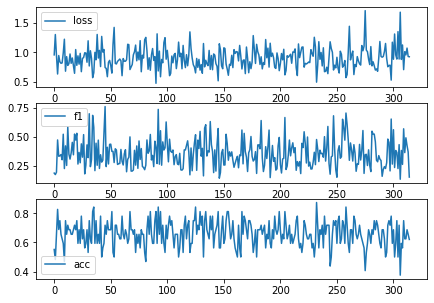

In [ ]:
fig = plt.figure(figsize=(7,5))
plt.subplot(3,1,1)
plt.plot(loss_list, label='loss')
#plt.plot(valid_loss_list, label='valid loss')
plt.legend()
plt.subplot(3,1,2)
plt.plot(f1_list, label='f1')
#plt.plot(valid_f1_list, label='valid f1')
plt.legend()
plt.subplot(3,1,3)
plt.plot(acc_list, label='acc')
#plt.plot(valid_acc_list, label='valid acc')
plt.legend()

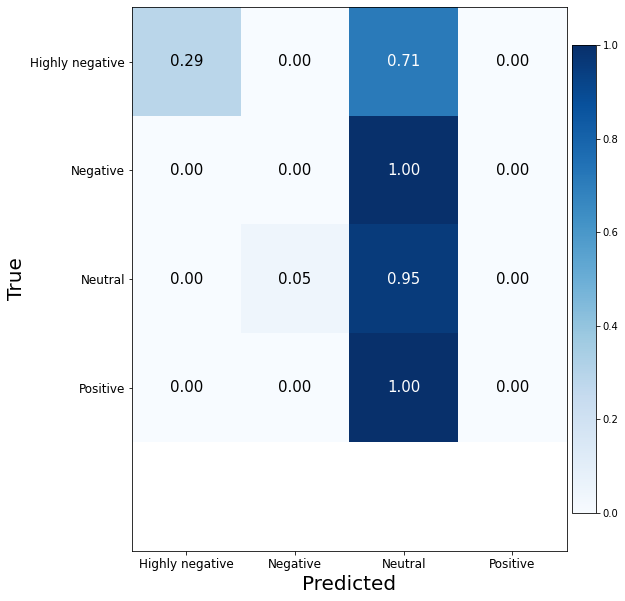

Loss:0.88, F1:0.32, Acc:0.72


In [ ]:
eval_model()

In [ ]:
train_model(EPOCHS=2,LEARNING_RATE = 0.01,WEIGHT_DECAY = 0.0001)

  0%|          | 0/628 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: ignored

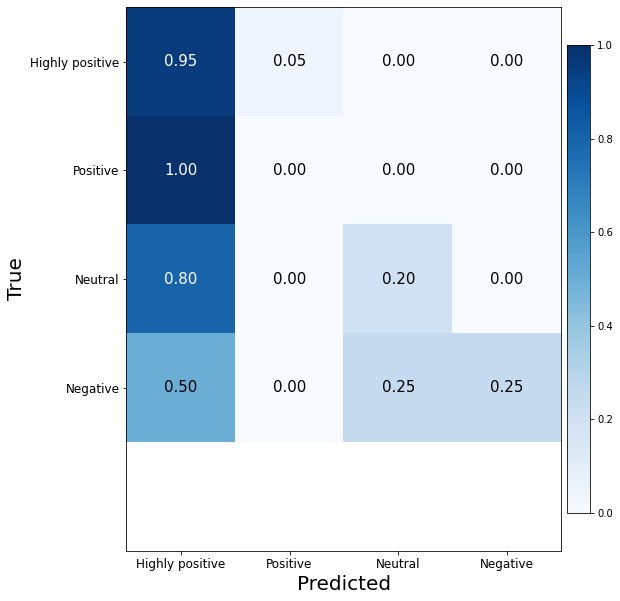

Loss:0.77, F1:0.38, Acc:0.72


In [ ]:
eval_model(classes=5)

In [ ]:
train_model(EPOCHS=10,LEARNING_RATE = 0.05,WEIGHT_DECAY = 0.0001)

  0%|          | 0/850 [00:00<?, ?it/s]

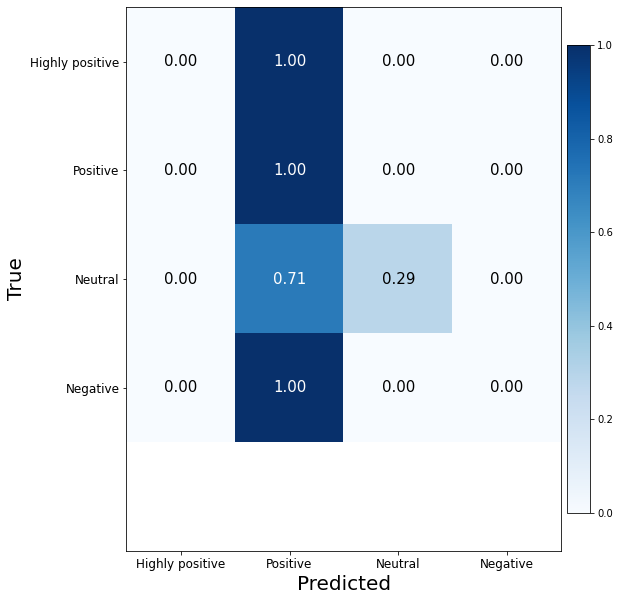

Loss:1.87, F1:0.31, Acc:0.69


In [ ]:
eval_model(classes=5)

In [ ]:
train_model(EPOCHS=5,LEARNING_RATE = 0.1,WEIGHT_DECAY = 0.0001)

  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


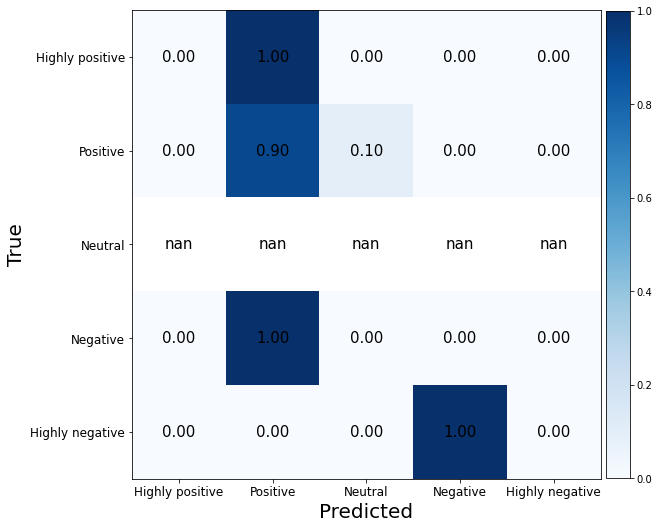

Loss:3.88, F1:0.15, Acc:0.59


In [ ]:
eval_model(classes=5)

In [ ]:
train_model(EPOCHS=5,LEARNING_RATE = 0.01,WEIGHT_DECAY = 0.001)

  0%|          | 0/425 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


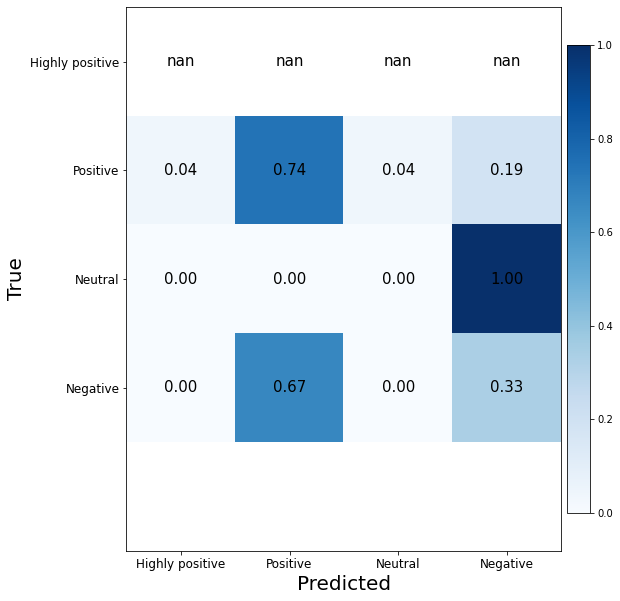

Loss:1.55, F1:0.25, Acc:0.66


In [ ]:
eval_model(classes=5)

In [ ]:
train_model(EPOCHS=5,LEARNING_RATE = 0.01,WEIGHT_DECAY = 0.005)

  0%|          | 0/425 [00:00<?, ?it/s]

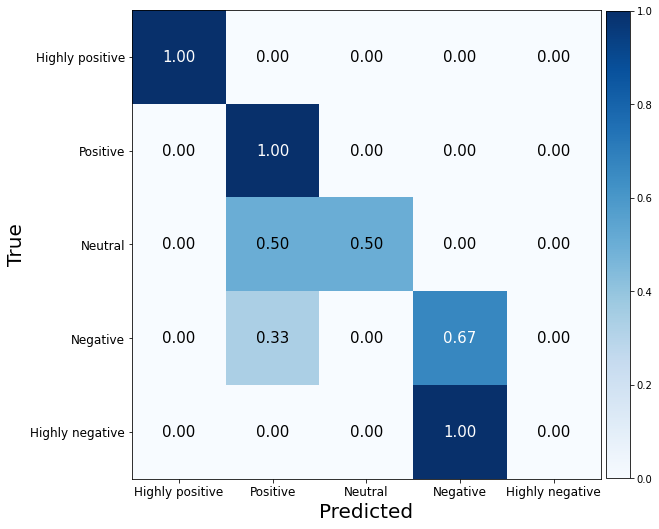

Loss:0.63, F1:0.67, Acc:0.88


In [ ]:
eval_model(classes=5)

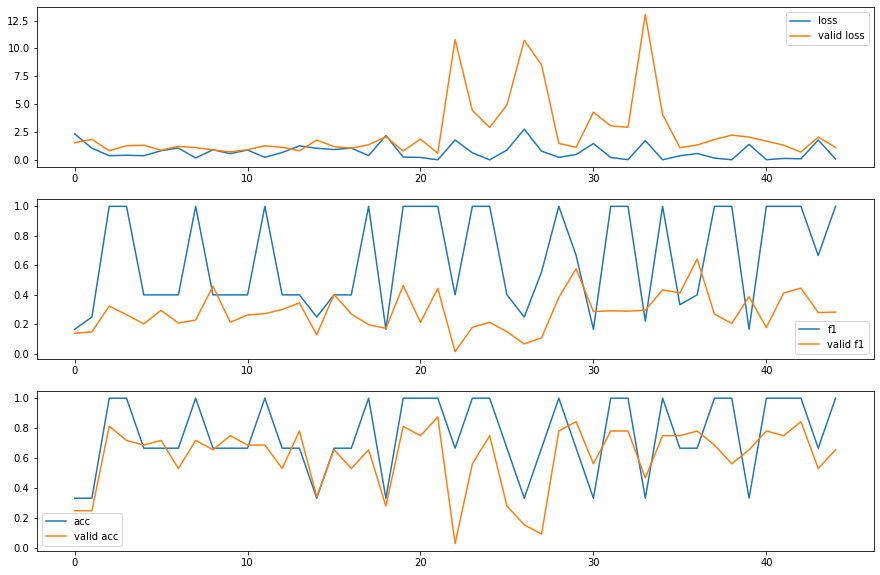

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(loss_list, label='loss')
plt.plot(valid_loss_list, label='valid loss')
plt.legend()
plt.subplot(3,1,2)
plt.plot(f1_list, label='f1')
plt.plot(valid_f1_list, label='valid f1')
plt.legend()
plt.subplot(3,1,3)
plt.plot(acc_list, label='acc')
plt.plot(valid_acc_list, label='valid acc')
plt.legend()